In [3]:
from plot_lib import *
from experiment_lib import load_constants_from_config
import json

In [4]:
# parse config
path = "exp-configs/EMEA/100/config-125M-en.json"

with open(path, "r") as f:
    config = json.load(f)

# Load constants from config
(
    ROOT_DIR, 
    DATASET_DIR, 
    SOURCE_DIR, 
    DATASET_NAME, 
    EXPERIMENT_NAME, 
    NUM_TRIALS, 
    PREFIX_LEN, 
    SUFFIX_LEN, 
    PREPREFIX_LEN, 
    LANGUAGE, 
    SPLIT, 
    EXAMPLE_TOKEN_LEN, 
    SOURCE_FILE, 
    BATCH_SIZE, 
    MODEL_NAME, 
    TRAIN_FILE, 
    VAL_FILE, 
    VAL_SPLIT, 
    SEED
) = load_constants_from_config(config)

In [3]:
plot_max_BLEU(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS)

tmp/europarl/en/en-100-100-6B/bleu_scores/sorted_compl_bleu_scores.jsonl


FileNotFoundError: [Errno 2] No such file or directory: 'tmp/europarl/en/en-100-100-6B/bleu_scores/sorted_compl_bleu_scores.jsonl'

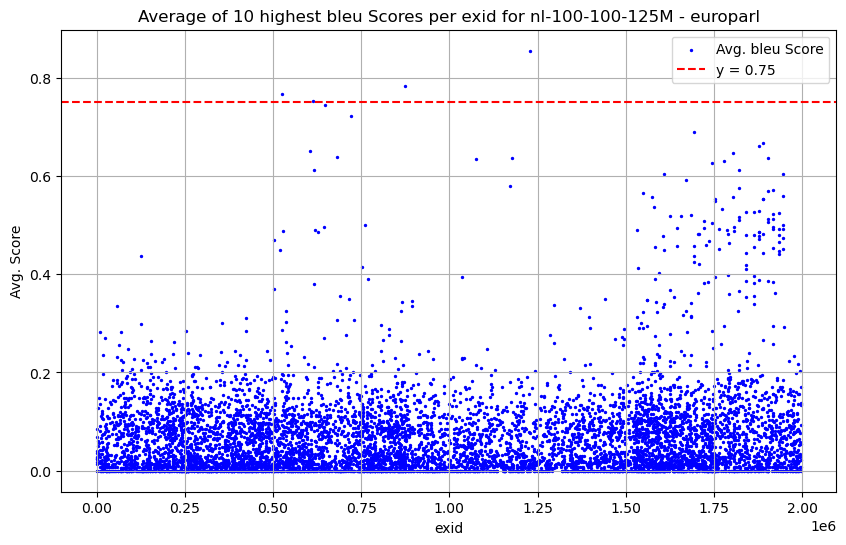

In [8]:
avg_10_highest_score(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS, isMeteor=False)

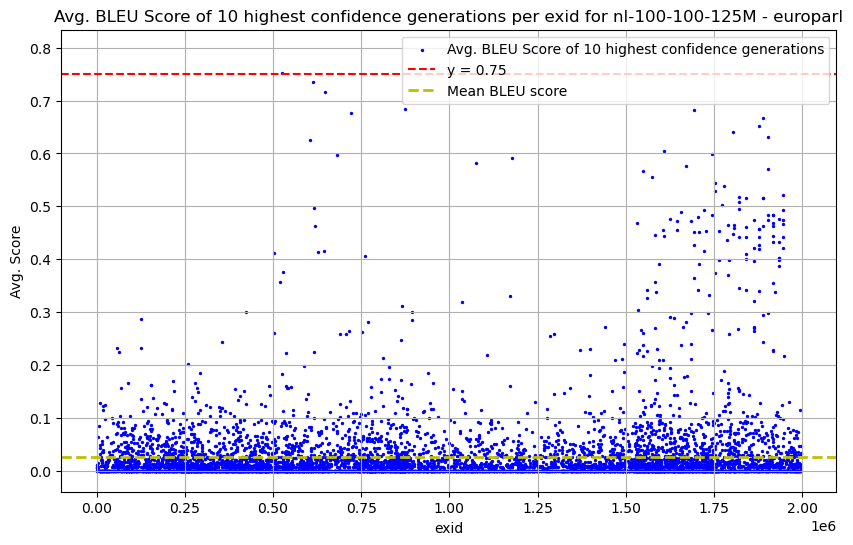

In [10]:
avg_10_highest_conf(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS)

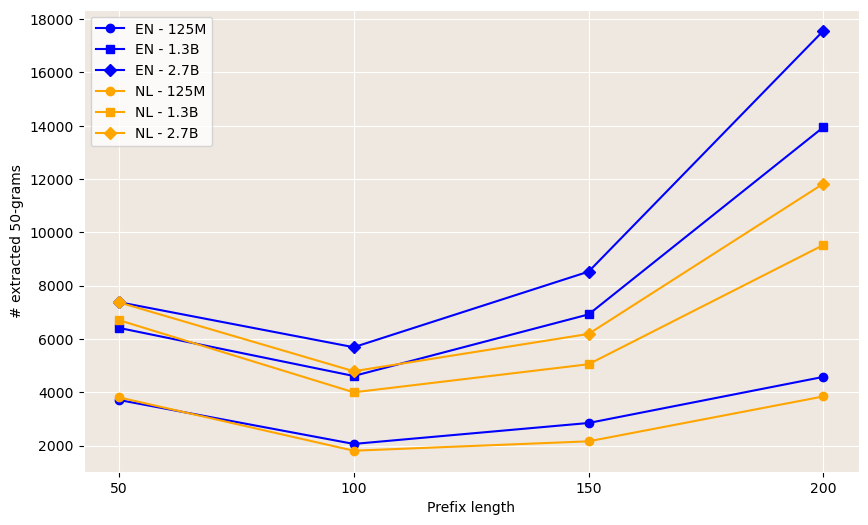

In [38]:
base = os.path.join(ROOT_DIR, DATASET_DIR)
# model_sizes = ["125M", "1.3B", "2.7B", "6B"]
# model_sizes = [125000000, 1300000000, 2700000000, 6000000000]
model_sizes = ["125M", "1.3B", "2.7B"]
languages = ["en", "nl"]
epochs = [100, 150, 200, 250]

# Initialize a dictionary to hold scores
scores = {lang: {token_len: [] for token_len in epochs} for lang in languages}

# Collect scores
for lang in languages:
    for size in model_sizes:
        for token_len in epochs:
            acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-{token_len}-100-{size}", "accuracy.jsonl")
            with open(acc_file, 'r') as file:
                data = json.loads(file.readline())
                scores[lang][token_len].append((size, data['num_correct'], data['num_exact_match']))


# Reorganize data for plotting
scores_by_size = {lang: {size: [] for size in model_sizes} for lang in languages}
for lang in languages:
    for size in model_sizes:
        for token_len in epochs:
            _, num_correct, _ = scores[lang][token_len][model_sizes.index(size)]
            scores_by_size[lang][size].append((token_len, num_correct))

markers = ['o', 's', 'D', '^', 'h']
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for lang in languages:
    for size_index, size in enumerate(model_sizes):
        token_lens = [token_len -50  for token_len, _ in scores_by_size[lang][size]]
        corrects = [correct for _,  correct in scores_by_size[lang][size]]
        label = f'{lang.upper()} - {size}'
        color = 'blue' if lang == "en" else 'orange'
        marker = markers[size_index]
        ax.plot(token_lens, corrects, label=label, color=color, marker=marker)

ax.set_xlabel('Prefix length')
ax.set_ylabel('# extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks([tl - 50 for tl in epochs])
ax.set_xticklabels([str(tl - 50) for tl in epochs])
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

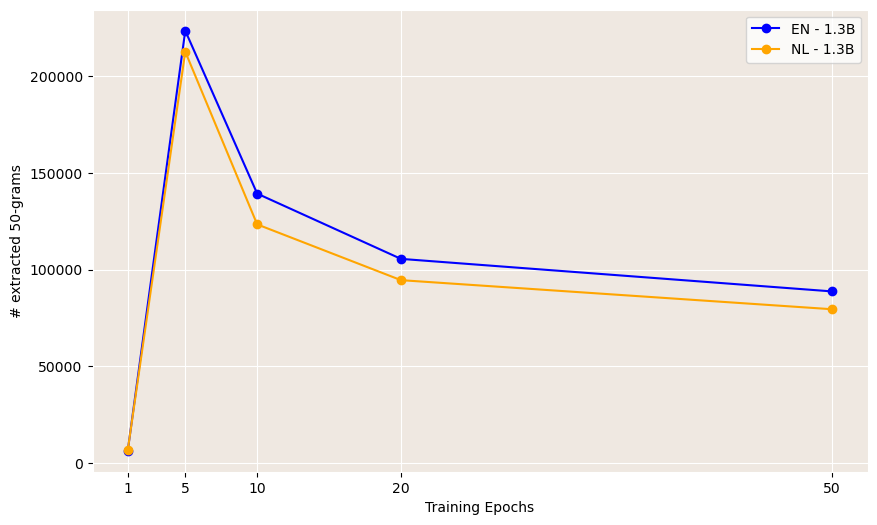

In [6]:
import os

base = os.path.join(ROOT_DIR, DATASET_DIR)
languages = ["en", "nl"]
epochs = [1, 5, 10, 20, 50]

# Initialize a dictionary to hold scores
scores = {lang: {e: [] for e in epochs} for lang in languages}

# Collect scores
for lang in languages:
    for e in epochs:
        if e == 1:
            acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-100-100-1.3B", "accuracy.jsonl")
        else:
            acc_file = os.path.join(ROOT_DIR, DATASET_DIR, lang, f"{lang}-100-100-1.3B-E{e}", "accuracy.jsonl")
        with open(acc_file, 'r') as file:
            data = json.loads(file.readline())
            # Corrected to use epochs as keys and directly store the number of correct answers
            scores[lang][e] = data['num_correct']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for lang in languages:
    corrects = [scores[lang][e] for e in epochs]
    label = f'{lang.upper()} - 1.3B'
    color = 'blue' if lang == "en" else 'orange'
    ax.plot(epochs, corrects, label=label, color=color, marker='o')  # Use 'o' as a generic marker

ax.set_xlabel('# epochs')
ax.set_ylabel('# extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks(epochs)
ax.set_xticklabels([str(e) for e in epochs])
for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

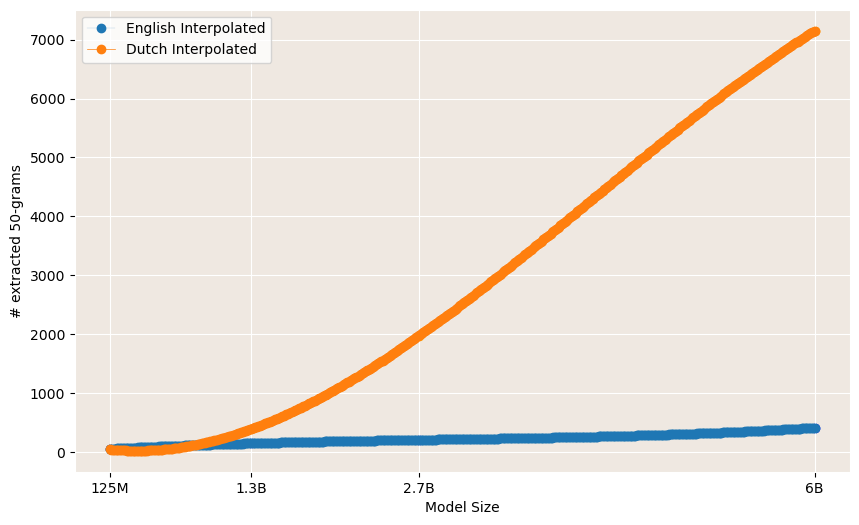

In [75]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Assuming ROOT_DIR, DATASET_DIR, EXAMPLE_TOKEN_LEN, and NUM_TRIALS are defined
base = os.path.join(ROOT_DIR, DATASET_DIR)
model_sizes = ["125M", "1.3B", "2.7B", "6B"]
model_sizes_numeric = [125, 1300, 2700, 6000]  # Convert model sizes to a numeric scale for interpolation
languages = ["en", "nl"]

en_scores = []
nl_scores = []

for lang in languages:
    for size, size_numeric in zip(model_sizes, model_sizes_numeric):
        acc_file = os.path.join(base, lang, f"{lang}-{EXAMPLE_TOKEN_LEN}-{NUM_TRIALS}-{size}", "accuracy.jsonl")
        with open(acc_file, 'r') as file:
            data = json.loads(file.readline())
            correct = data['num_correct']
            exact = data['num_exact_match']
            if lang == "en":
                en_scores.append((size_numeric, correct, exact))
            if lang == "nl":
                nl_scores.append((size_numeric, correct, exact))

# Interpolation
en_scores_sorted = sorted(en_scores, key=lambda x: x[0])  # Ensure the scores are sorted by model size
nl_scores_sorted = sorted(nl_scores, key=lambda x: x[0])

# Extracting the scores and sizes
en_sizes, en_correct, _ = zip(*en_scores_sorted)
nl_sizes, nl_correct, _ = zip(*nl_scores_sorted)

# Creating interpolation functions
en_interp = interp1d(en_sizes, en_correct, kind='cubic')
nl_interp = interp1d(nl_sizes, nl_correct, kind='cubic')

# New domain for interpolation
interp_domain = np.linspace(min(en_sizes), max(en_sizes), 500)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(interp_domain, en_interp(interp_domain), label='English', marker='o',linewidth=0.5)
ax.plot(interp_domain, nl_interp(interp_domain), label='Dutch', marker='o', linewidth=0.5)
ax.scatter(en_sizes, en_correct, color='blue')  # Original data points
ax.scatter(nl_sizes, nl_correct, color='orange')  # Original data points
ax.set_xlabel('Model Size')
ax.set_ylabel('# extracted 50-grams')
ax.legend()
plt.grid(True, color='white')
ax.set_facecolor('#efe8e1')
ax.set_xticks(model_sizes_numeric)
ax.set_xticklabels(['125M', '1.3B', '2.7B', '6B'])

for spine in ax.spines.values():
    spine.set_edgecolor('white')

plt.show()

In [28]:

def get_losses_of_correct_guesses(exp_name: str, language: str):
    acc_path = os.path.join(f"tmp/europarl/{language}", exp_name, "accuracy.jsonl")
    losses_base = os.path.join(f"tmp/europarl/{language}", exp_name, "losses/decoded")

    losses_file_pattern = os.path.join(losses_base, "decoded_losses_trial_")

    with open(acc_path, 'r') as file:
        print(f"Reading accuracy file: {acc_path}")
        lines = file.readlines()
        # Load the first line
        data = json.loads(lines[0])

        # Get the number of correct guesses
        correct = data['num_correct']
        exact = data['num_exact_match']
        print(f"Number of correct guesses: {correct}")
        print(f"Number of exact matches: {exact}")

        losses_total = []

        for line in lines[1:]:
            data = json.loads(line)
            exid = data['exid']
            exac = data['trials_exact']
            corr = data['trials_correct']
            losses = []

            for trial in exac:
                trial_num = trial['trial']
                print(f"Trial: {trial_num}")
                # load the loss from loss file
                with open(f"{losses_file_pattern}{trial_num}.jsonl", 'r') as loss_file:
                    lines = loss_file.readlines()
                    for line in lines:
                        loss_data = json.loads(line)
                        if str(loss_data['exid']) == exid:
                            loss = loss_data['loss']
                            losses.append({
                                "trial": trial_num,
                                "loss": loss
                            })
            
            # append each exid even if there were no losses (in case no exact match was found)
            losses_total.append({
                "exid": exid,
                "losses": losses
            })

        # save losses_total
        with open(os.path.join(f"tmp/europarl/{language}", exp_name, "exact_match_guess_losses.jsonl"), 'w') as file:
            for item in losses_total:
                file.write(json.dumps(item) + "\n")

In [32]:
# get_losses_of_correct_guesses("nl-100-100-6B", "nl")
# get_losses_of_correct_guesses("nl-100-100-125M", "nl")
# get_losses_of_correct_guesses("nl-100-100-1.3B", "nl")
# get_losses_of_correct_guesses("nl-100-100-2.7B", "nl")

get_losses_of_correct_guesses("en-100-100-6B", "en")
get_losses_of_correct_guesses("en-100-100-125M", "en")
get_losses_of_correct_guesses("en-100-100-1.3B", "en")
get_losses_of_correct_guesses("en-100-100-2.7B", "en")

Reading accuracy file: tmp/europarl/en/en-100-100-6B/accuracy.jsonl
Number of correct guesses: 409
Number of exact matches: 37
Trial: 10
Trial: 11
Trial: 13
Trial: 19
Trial: 22
Trial: 27
Trial: 38
Trial: 48
Trial: 49
Trial: 52
Trial: 61
Trial: 63
Trial: 69
Trial: 70
Trial: 71
Trial: 80
Trial: 83
Trial: 85
Trial: 94
Trial: 95
Trial: 99
Trial: 1
Trial: 4
Trial: 8
Trial: 23
Trial: 25
Trial: 33
Trial: 34
Trial: 38
Trial: 59
Trial: 60
Trial: 63
Trial: 65
Trial: 66
Trial: 78
Trial: 83
Trial: 92
Reading accuracy file: tmp/europarl/en/en-100-100-125M/accuracy.jsonl
Number of correct guesses: 49
Number of exact matches: 0
Reading accuracy file: tmp/europarl/en/en-100-100-1.3B/accuracy.jsonl
Number of correct guesses: 144
Number of exact matches: 16
Trial: 4
Trial: 12
Trial: 35
Trial: 36
Trial: 45
Trial: 51
Trial: 60
Trial: 75
Trial: 5
Trial: 15
Trial: 21
Trial: 24
Trial: 59
Trial: 86
Trial: 87
Trial: 89
Reading accuracy file: tmp/europarl/en/en-100-100-2.7B/accuracy.jsonl
Number of correct gues

In [102]:
import json
import matplotlib.pyplot as plt

# Filepaths to your JSONL files
filepath_losses = os.path.join("tmp/europarl/nl", exp_name, "correct_guess_losses.jsonl")
filepath_scores = os.path.join("tmp/europarl/nl", exp_name, "accuracy.jsonl")

# Initialize dictionaries to hold the data
losses_dict = {}
scores_dict = {}

# Load the data from the losses JSONL file
with open(filepath_losses, 'r') as file:
    for line in file:
        data = json.loads(line)
        for item in data['losses']:
            losses_dict[(data['exid'], item['trial'])] = item['loss']

# Load the data from the scores JSONL file
with open(filepath_scores, 'r') as file:
    lines = file.readlines()
    for line in lines[1:]:
        data = json.loads(line)
        print(data)
        for item in data['trials_correct']:
            scores_dict[(data['exid'], item['trial'])] = item['score']

# Create lists for plotting
exids = []
trials = []
losses = []
scores = []

for key in losses_dict.keys():
    if key in scores_dict:
        exids.append(key[0])
        trials.append(key[1])
        losses.append(losses_dict[key])
        scores.append(scores_dict[key])

# Create the plot
plt.figure(figsize=(10, 6))
for exid, trial, score, loss in zip(exids, trials, scores, losses):
    plt.scatter(loss, score, label=f'exid: {exid}')
plt.ylabel('Score')
plt.xlabel('Loss')
plt.title('Loss vs Score: ' + exp_name)
plt.grid(True)
plt.show()

{'exid': '83', 'scores': [{'trial': 94, 'score': 0.08032354490095452}, {'trial': 78, 'score': 0.07918391511662133}, {'trial': 7, 'score': 0.07047448671491263}, {'trial': 30, 'score': 0.06957653920684007}, {'trial': 38, 'score': 0.06446239417777984}, {'trial': 80, 'score': 1.9517452248976023e-78}, {'trial': 59, 'score': 1.8196578122273207e-78}, {'trial': 32, 'score': 1.6933824019618624e-78}, {'trial': 41, 'score': 1.6933824019618624e-78}, {'trial': 52, 'score': 1.6933824019618624e-78}, {'trial': 50, 'score': 1.6679107487892666e-78}, {'trial': 51, 'score': 1.6679107487892666e-78}, {'trial': 79, 'score': 1.6412155631049244e-78}, {'trial': 48, 'score': 1.5301437312903484e-78}, {'trial': 39, 'score': 1.5071274944483796e-78}, {'trial': 36, 'score': 1.4830056711772711e-78}, {'trial': 3, 'score': 1.4308886378873425e-78}, {'trial': 43, 'score': 1.4308886378873425e-78}, {'trial': 74, 'score': 1.4308886378873425e-78}, {'trial': 99, 'score': 5.933924816374188e-155}, {'trial': 64, 'score': 5.849734

KeyError: 'trials_correct'

In [33]:
from math import exp
import os

def avg_perplexity(exp_name, language):
    filepath_losses = os.path.join("tmp/europarl/", language, exp_name, "exact_match_guess_losses.jsonl")
    # filepath_losses = os.path.join("tmp/europarl/", language, exp_name, "correct_guess_losses.jsonl")

    out_file = f'tmp/europarl/{language}/average_perplexity.jsonl'

    # load all values in file
    with open(filepath_losses, 'r') as file:
        lines = file.readlines()
        
        # load all losses in a list
        losses = []
        for line in lines:
            data = json.loads(line)
            for item in data['losses']:
                # taking average of exact matches only 
                losses.append(exp(item['loss']))

        print(f"Total number of losses for {exp_name}: {len(losses)}")

        if len(losses) == 0:
            avg = 0
        else:
            avg = sum(losses) / len(losses)

        print(f"Average perplexity: {avg}")

    with open(out_file, 'a') as file:
        file.write(json.dumps({"experiment_name": exp_name,
                            "average_perplexity_EM": avg}) + "\n")

# avg_perplexity("nl-100-100-125M", "nl")        
# avg_perplexity("nl-100-100-1.3B", "nl")        
# avg_perplexity("nl-100-100-2.7B", "nl")
# avg_perplexity("nl-100-100-6B", "nl")

avg_perplexity("en-100-100-125M", "en")
avg_perplexity("en-100-100-1.3B", "en")
avg_perplexity("en-100-100-2.7B", "en")
avg_perplexity("en-100-100-6B", "en")


Total number of losses for en-100-100-125M: 0
Average perplexity: 0
Total number of losses for en-100-100-1.3B: 16
Average perplexity: 1.0587562264039063
Total number of losses for en-100-100-2.7B: 93
Average perplexity: 1.0272684290085883
Total number of losses for en-100-100-6B: 37
Average perplexity: 1.0414138720360564


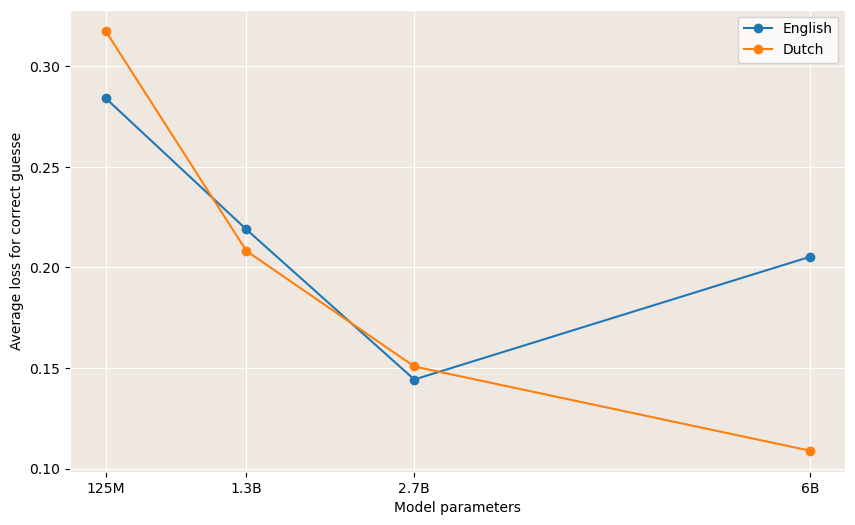

In [48]:
import json
import matplotlib.pyplot as plt
def plot_average_loss(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    # add 6B here
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])      

    # Create the plot
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, average_losses_en, 'o-', label='English')
    ax.plot(model_sizes, average_losses_nl, 'o-', label='Dutch')
    ax.set_ylabel('Average loss for correct guesse')
    ax.set_xlabel('Model parameters')
    # ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')  # Set the grid line color
    ax.set_facecolor('#efe8e1')  # Set the background color
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B', '6B'])

    # Set the color of the spines to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')


    # save figure
    plt.savefig('tmp/europarl/average_loss.png')

    plt.show()




nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss(en, nl)

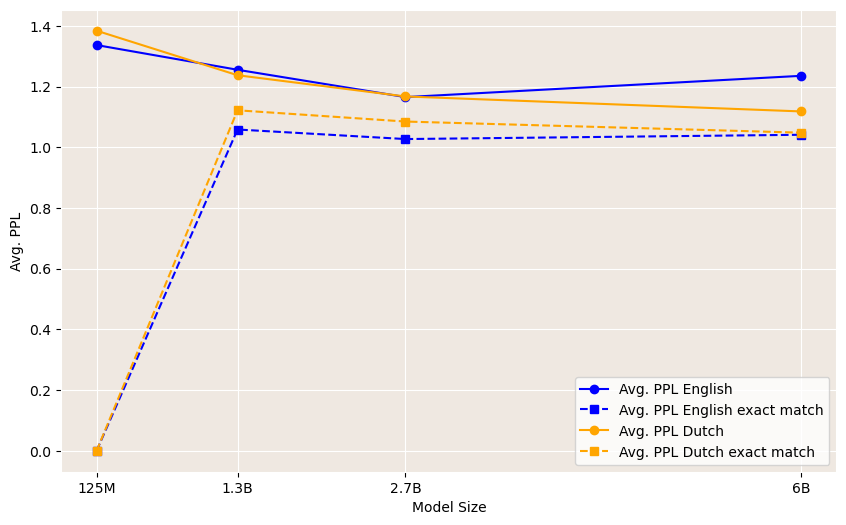

In [58]:
import json
import matplotlib.pyplot as plt

def plot_perplexities(file1, file2):

    # Initialize lists to hold the perplexities
    avg_perplexities_en = []
    avg_perplexities_en_em = []
    avg_perplexities_nl = []
    avg_perplexities_nl_em = []


    # Load the data from the JSONL files
    data1 = []

    # assumption: file 1 is English and file 2 is Dutch
    with open(file1, 'r') as file:
        for line in file:  # only read the first two lines
            data = json.loads(line)
            if data.get('average_perplexity') is not None:
                avg_perplexities_en.append(data['average_perplexity'])
            else:
                avg_perplexities_en_em.append(data['average_perplexity_EM'])

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data = json.loads(line)
            if data.get('average_perplexity') is not None:
                avg_perplexities_nl.append(data['average_perplexity'])
            else:
                avg_perplexities_nl_em.append(data['average_perplexity_EM'])

    # Extract the model sizes
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, avg_perplexities_en, 'o-', color='blue', label='Avg. PPL English')
    ax.plot(model_sizes, avg_perplexities_en_em, 's--', color='blue', label='Avg. PPL English exact match')
    ax.plot(model_sizes, avg_perplexities_nl, 'o-', color='orange', label='Avg. PPL Dutch')
    ax.plot(model_sizes, avg_perplexities_nl_em, 's--', color='orange', label='Avg. PPL Dutch exact match')

    ax.set_ylabel("Avg. PPL")
    ax.set_xlabel('Model Size')
    ax.legend()
    plt.grid(True, color='white')
    ax.set_facecolor('#efe8e1')
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B', '6B'])

    for spine in ax.spines.values():
        spine.set_edgecolor('white')

    # Save and show the figure
    plt.savefig('tmp/europarl/perplexity_comparison.png')
    plt.show()

# File paths
nl = "tmp/europarl/nl/average_perplexity.jsonl"
en = "tmp/europarl/en/average_perplexity.jsonl"

# Call the function
plot_perplexities(en, nl)

NameError: name 'model_sizes_numeric' is not defined

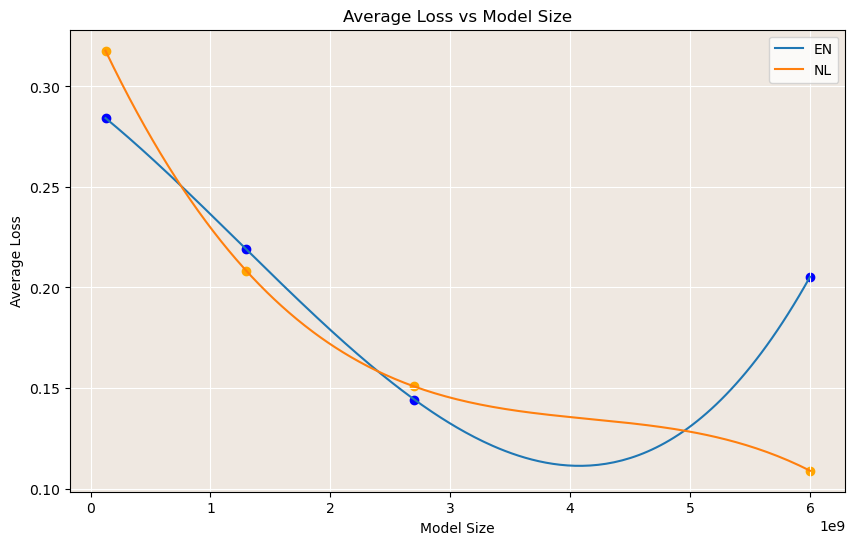

In [50]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

def plot_average_loss_interpolated(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])

    # Create the cubic spline interpolation functions
    cs_en = CubicSpline(model_sizes, average_losses_en)
    cs_nl = CubicSpline(model_sizes, average_losses_nl)

    # Create an array of x values for the interpolated function
    xs = np.logspace(np.log10(min(model_sizes)), np.log10(max(model_sizes)), 500)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(xs, cs_en(xs), label='EN')
    ax.plot(xs, cs_nl(xs), label='NL')
    ax.scatter(model_sizes, average_losses_en, color='blue')
    ax.scatter(model_sizes, average_losses_nl, color='orange')
    ax.set_ylabel('Average Loss')
    ax.set_xlabel('Model Size')
    ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')
    ax.set_facecolor('#efe8e1')
    ax.set_xticks(model_sizes_numeric)
    ax.set_xticklabels(['125M', '1.3B', '2.7B', '6B'])

    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        
    plt.show()

nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss_interpolated(en, nl)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

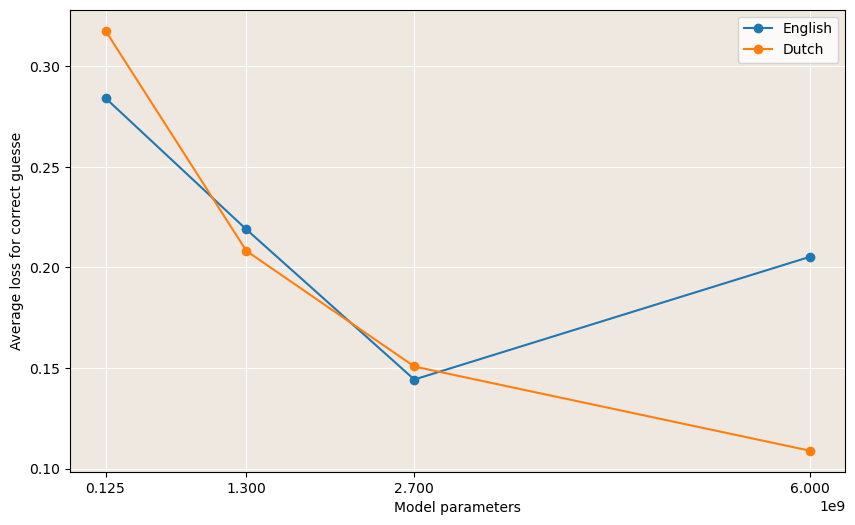

In [52]:
import json
import matplotlib.pyplot as plt
def plot_average_loss(file1, file2):
    # Load the data from the JSONL file
    data1 = []
    with open(file1, 'r') as file:
        for line in file:
            data1.append(json.loads(line))

    data2 = []
    with open(file2, 'r') as file:
        for line in file:
            data2.append(json.loads(line))

    # Extract the model sizes and average losses
    # add 6B here
    model_sizes = [125000000, 1300000000, 2700000000, 6000000000]

    average_losses_en = []
    average_losses_nl = []
    for data in data1:
        average_losses_en.append(data['average_loss'])

    for data in data2:
         average_losses_nl.append(data['average_loss'])      

    # Create the plot
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_sizes, average_losses_en, 'o-', label='English')
    ax.plot(model_sizes, average_losses_nl, 'o-', label='Dutch')
    ax.set_ylabel('Average loss for correct guesse')
    ax.set_xlabel('Model parameters')
    # ax.set_title('Average Loss vs Model Size')
    ax.legend()
    plt.grid(True, color='white')  # Set the grid line color
    ax.set_facecolor('#efe8e1')  # Set the background color
    ax.set_xticks(model_sizes)
    ax.set_xticklabels(['125M', '1.3B', '2.7B, 6B'])

    # Set the color of the spines to white
    for spine in ax.spines.values():
        spine.set_edgecolor('white')


    # save figure
    plt.savefig('tmp/europarl/average_loss.png')

    plt.show()




nl = "tmp/europarl/nl/average_loss.jsonl"
en = "tmp/europarl/en/average_loss.jsonl"

plot_average_loss(en, nl)

In [32]:
import json
import pandas as pd
import matplotlib.pyplot as plt

scores = "tmp/europarl/nl/nl-100-100-2.7B/bleu_scores/sorted_compl_bleu_scores.jsonl"
losses = "tmp/europarl/nl/nl-100-100-2.7B/losses/decoded/sorted_compl_losses.jsonl"
# Load the data
with open(scores, 'r') as f:
    scores_data = [json.loads(line) for line in f]
with open(losses, 'r') as f:
    losses_data = [json.loads(line) for line in f]

# Convert to pandas DataFrame
scores_df = pd.json_normalize(scores_data, 'scores', ['exid'])
losses_df = pd.json_normalize(losses_data, 'losses', ['exid'])

# Merge the two DataFrames
merged_df = pd.merge(scores_df, losses_df, on=['exid', 'trial'])

# Plot the data
plt.scatter(merged_df['loss'], merged_df['score'], s=1, marker='x', alpha=0.1)
plt.axhline(y=0.75, color='r', linestyle='--')
plt.xlabel('Loss')
plt.ylabel('Score')
plt.show()

KeyboardInterrupt: 

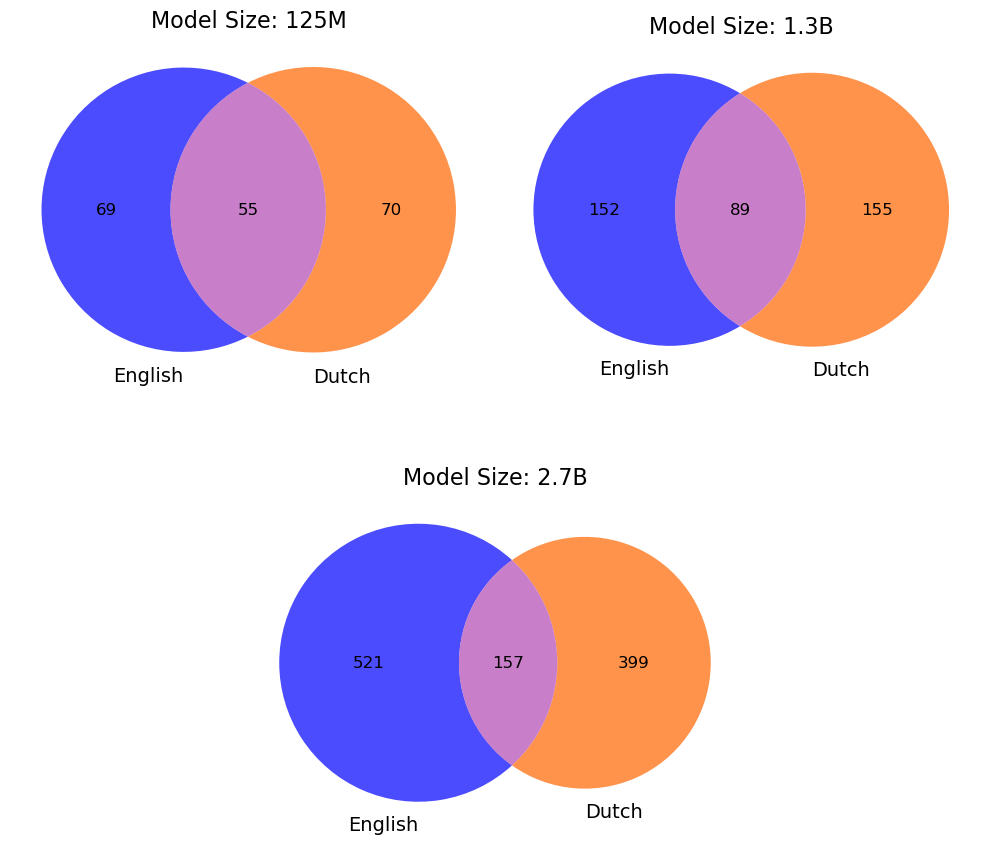

In [49]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import json
import matplotlib.gridspec as gridspec

model_sizes = ["125M", "1.3B", "2.7B"]

def load_unique_exids(path):
    exids = []
    with open(path, "r") as in_nl:
        next(in_nl)  # Skip the first line
        for line in in_nl:
            exids.append(int(json.loads(line)["exid"]))
    return exids

plt.figure(figsize=(10, 10))

# Create a GridSpec with 2 rows and 2 columns
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.5])  # Adjust the height ratio of the rows

# Top row positions
positions = [(0, 0), (0, 1)]

# Loop through the top row positions
for i, (row, col) in enumerate(positions):
    acc_nl = f"tmp/EMEA/nl/nl-100-100-{model_sizes[i]}/accuracy.jsonl"
    acc_en = f"tmp/EMEA/en/en-100-100-{model_sizes[i]}/accuracy.jsonl"

    nl_exids = load_unique_exids(acc_nl)
    en_exids = load_unique_exids(acc_en)

    common_exids = list(set(nl_exids) & set(en_exids))

    ax = plt.subplot(gs[row, col])
    v = venn2(
        subsets=(len(en_exids), len(nl_exids), len(common_exids)),
        set_labels=("English", "Dutch"),
        set_colors=((0, 0, 1), (1, 0.4, 0)),
        alpha=0.7,
    )
    
    # Increase label sizes
    for text in v.set_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(14)  # Adjust the size as needed
    for text in v.subset_labels:
        if text:  # Check if the label is not None
            text.set_fontsize(12)  # Adjust the size as needed

    ax.set_title(f"Model Size: {model_sizes[i]}", fontsize=16)  # Increase title size

# Position for the third Venn diagram in the bottom middle
acc_nl = f"tmp/EMEA/nl/nl-250-100-{model_sizes[2]}/accuracy.jsonl"
acc_en = f"tmp/EMEA/en/en-250-100-{model_sizes[2]}/accuracy.jsonl"

nl_exids = load_unique_exids(acc_nl)
en_exids = load_unique_exids(acc_en)

common_exids = list(set(nl_exids) & set(en_exids))

ax = plt.subplot(gs[1, :])
v = venn2(
    subsets=(len(en_exids), len(nl_exids), len(common_exids)),
    set_labels=("English", "Dutch"),
    set_colors=((0, 0, 1), (1, 0.4, 0)),
    alpha=0.7,
)

# Increase label sizes
for text in v.set_labels:
    if text:  # Check if the label is not None
        text.set_fontsize(14)  # Adjust the size as needed
for text in v.subset_labels:
    if text:  # Check if the label is not None
        text.set_fontsize(12)  # Adjust the size as needed

ax.set_title(f"Model Size: {model_sizes[2]}", fontsize=16)  # Increase title size

plt.tight_layout()
plt.show()
 

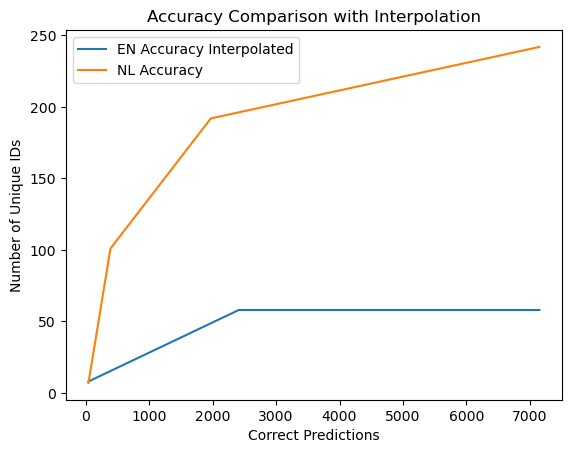

In [67]:
# number of extracted vs unique extracted

from matplotlib import pyplot as plt
import json

model_sizes = ["125M", "1.3B", "2.7B", "6B"]

x_nl = []
x_en = []

y_nl = []
y_en = []


def load_unique_exids(path):
    exids = []
    num_correct = None  # Initialize variable to store num_correct
    with open(path, "r") as in_nl:
        first_line = True  # Flag to check if it's the first line
        for line in in_nl:
            if first_line:
                # Extract num_correct from the first line and convert to int
                num_correct = int(json.loads(line)['num_correct'])
                first_line = False  # Update flag so this block doesn't run again
                continue  # Skip the rest of the loop and move to the next iteration
            # For all other lines, extract exid as before
            exids.append(int(json.loads(line)["exid"]))
    return exids, num_correct  # Return both exids and num_correct

for i in range(len(model_sizes)):
    acc_nl = f"tmp/europarl/nl/nl-100-100-{model_sizes[i]}/accuracy.jsonl"
    acc_en = f"tmp/europarl/en/en-100-100-{model_sizes[i]}/accuracy.jsonl"

    nl_exids, nl_correct = load_unique_exids(acc_nl)
    en_exids, en_correct = load_unique_exids(acc_en)

    x_nl.append(nl_correct)
    x_en.append(en_correct)

    y_nl.append(len(nl_exids))
    y_en.append(len(en_exids))

    
# Define the new x domain as the range of x_nl
new_x_domain = np.linspace(min(x_nl), max(x_nl), num=len(x_nl))

# Interpolate y_en values over the new x domain
new_y_en = np.interp(new_x_domain, x_en, y_en)

# Now, you can plot using the new_x_domain and new_y_en for EN, and x_nl and y_nl for NL

plt.plot(new_x_domain, new_y_en, label='EN Accuracy Interpolated')  # Plot for EN interpolated
plt.plot(x_nl, y_nl, label='NL Accuracy')  # Plot for NL

# Adding labels and legend
plt.xlabel('Correct Predictions')  # Adjust label as per your data
plt.ylabel('Number of Unique IDs')  # Adjust label as per your data
plt.title('Accuracy Comparison with Interpolation')  # Title for your plot
plt.legend()  # To add a legend to differentiate the lines

# Show the plot
plt.show()

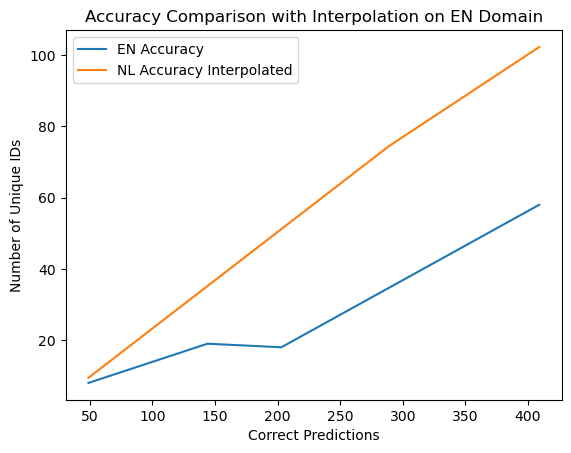

In [63]:
from matplotlib import pyplot as plt
import json
import numpy as np
from scipy.signal import savgol_filter

model_sizes = ["125M", "1.3B", "2.7B", "6B"]

x_nl = []
x_en = []

y_nl = []
y_en = []

def load_unique_exids(path):
    exids = []
    num_correct = None  # Initialize variable to store num_correct
    with open(path, "r") as in_nl:
        first_line = True  # Flag to check if it's the first line
        for line in in_nl:
            if first_line:
                # Extract num_correct from the first line and convert to int
                num_correct = int(json.loads(line)['num_correct'])
                first_line = False  # Update flag so this block doesn't run again
                continue  # Skip the rest of the loop and move to the next iteration
            # For all other lines, extract exid as before
            exids.append(int(json.loads(line)["exid"]))
    return exids, num_correct  # Return both exids and num_correct

for i in range(len(model_sizes)):
    acc_nl = f"tmp/europarl/nl/nl-100-100-{model_sizes[i]}/accuracy.jsonl"
    acc_en = f"tmp/europarl/en/en-100-100-{model_sizes[i]}/accuracy.jsonl"

    nl_exids, nl_correct = load_unique_exids(acc_nl)
    en_exids, en_correct = load_unique_exids(acc_en)

    x_nl.append(nl_correct)
    x_en.append(en_correct)

    y_nl.append(len(nl_exids))
    y_en.append(len(en_exids))

# Adjust the x domain to use the original English domain and shrink the Dutch curve accordingly

# Define the new x domain as the range of x_en
new_x_domain_en = np.linspace(min(x_en), max(x_en), num=len(x_en))

# Interpolate y_nl values over the new x domain of English
new_y_nl = np.interp(new_x_domain_en, x_nl, y_nl)

# Plot using the new_x_domain_en for EN, and the interpolated values for NL

plt.plot(x_en, y_en, label='EN Accuracy')  # Plot for EN using its original domain
plt.plot(new_x_domain_en, new_y_nl, label='NL Accuracy Interpolated')  # Plot for NL interpolated to EN's domain

# Adding labels and legend
plt.xlabel('Correct Predictions')  # Adjust label as per your data
plt.ylabel('Number of Unique IDs')  # Adjust label as per your data
plt.title('Accuracy Comparison with Interpolation on EN Domain')  # Title for your plot
plt.legend()  # To add a legend to differentiate the lines

# Show the plot
plt.show()
